# Familiarization Task:
- data importing and preprocessing
- visualizations
- correlation matrix
- simple method for predicting next value

## Data importing and preprocessing

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

train_data1 = pd.read_csv('./data/BATADAL_dataset03.csv', sep = ',')
train_data2 = pd.read_csv('./data/BATADAL_dataset04.csv', sep = ', ')
test_data = pd.read_csv('./data/BATADAL_test_dataset.csv', sep = ',')

print("Train dataset 1 shape: ", train_data1.shape)
print("Train dataset 2 shape: ", train_data2.shape)
print("Test dataset shape: ", test_data.shape, "\n")

# Merge train dataset 1 and 2 into a single dataframe
# Convert DATETIME to numeric
train_data = pd.concat([train_data1, train_data2], axis=0, ignore_index=True)
train_data['DATETIME'] = pd.to_datetime(train_data['DATETIME'], dayfirst=True, infer_datetime_format=True)

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


Train dataset 1 shape:  (8761, 45)
Train dataset 2 shape:  (4177, 45)
Test dataset shape:  (2089, 44) 



Get the actual labels from batadal.net and append to a new list `ATT_FLAG_ACTUAL`

In [2]:
train_data['ATT_FLAG_ACTUAL'] = train_data['ATT_FLAG']

start_date = ['2016-09-13 23', '2016-09-26 11', '2016-10-09 09', '2016-10-29 19', '2016-11-26 17', '2016-12-06 07', '2016-12-14 15']
end_date = ['2016-09-16 00', '2016-09-27 10', '2016-10-11 20', '2016-11-02 16', '2016-11-29 04', '2016-12-10 04', '2016-12-19 04']

for i in range(len(start_date)):
    mask = (train_data['DATETIME']>=start_date[i]) & (train_data['DATETIME']<=end_date[i])
#     print("lab num: ", np.sum(mask.values))
    train_data['ATT_FLAG_ACTUAL'][mask] = 1

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Convert timestamp to numeric values for year, month, day, hour

In [3]:
train_data['Year'] = train_data['DATETIME'].apply(lambda x: x.year)
train_data['Month'] = train_data['DATETIME'].apply(lambda x: x.month)
train_data['Day'] = train_data['DATETIME'].apply(lambda x: x.day)
train_data['Hour'] = train_data['DATETIME'].apply(lambda x: x.hour)

test_data['DATETIME'] = pd.to_datetime(test_data['DATETIME'], infer_datetime_format=True)
test_data['Year'] = test_data['DATETIME'].apply(lambda x: x.year)
test_data['Month'] = test_data['DATETIME'].apply(lambda x: x.month)
test_data['Day'] = test_data['DATETIME'].apply(lambda x: x.day)
test_data['Hour'] = test_data['DATETIME'].apply(lambda x: x.hour)

Extract corresponding numpy arrays which will be used for learning

In [4]:
# Final versions of training and test dataframes
# Drop DATETIME and ATT_FLAG(labels) from train dataframe and DATETIME for test dataframe
# Convert labels of the tarining dataset 2 wihich are equalled to -999, to 0 
y = train_data['ATT_FLAG'].values
y[y==-999] = 0
y_actual = train_data['ATT_FLAG_ACTUAL'].values
y_actual[y_actual==-999] = 0

train_data = train_data.drop(columns=['DATETIME', 'ATT_FLAG', 'ATT_FLAG_ACTUAL'])
test_data = test_data.drop(columns=['DATETIME'])

# Training and test numpy arrays
X = train_data.values
X_test = test_data.values

# Drop columns with 0 variance as they can be of no use in the learning process
index = np.std(X, axis=0) != 0
X = X[:, index]
X_test = X_test[:, index]
print("Discarded features: ", train_data.columns[index==0], "\n")

# Drop them also from the train and test dataframes
train_data = train_data.drop(columns=train_data.columns[index==0])
test_data = test_data.drop(columns=test_data.columns[index==0])
print("new train df: ", len(test_data.columns))

# separate the two training datasets again
# X1, y1 = training data and labels 1 (normal behaviour)
# X2, y2 = training data and labels 2 (attacks present)
num = len(train_data1)
print("Num: ", num)
X1 = X[:num]
X2 = X[num:]
y1 = y[:num]
y2 = y[num:]
y2_actual = y_actual[num:]

# Check for NaNs
print("Number of NaN values in training dataset: ", np.sum(pd.isna(train_data).values))
print("Number of NaN values in test dataset: ", np.sum(pd.isna(train_data).values), "\n")


print("Training dataset shape: ", X.shape)
print("Test dataset shape: ", X_test.shape)
print("Number of labeled attacks: ", np.sum(y==1))
print("Number of labeled attacks: ", np.sum(y2_actual==1))

Discarded features:  Index(['S_PU1', 'F_PU3', 'S_PU3', 'F_PU5', 'S_PU5', 'F_PU9', 'S_PU9'], dtype='object') 

new train df:  40
Num:  8761
Number of NaN values in training dataset:  0
Number of NaN values in test dataset:  0 

Training dataset shape:  (12938, 40)
Test dataset shape:  (2089, 40)
Number of labeled attacks:  219
Number of labeled attacks:  492


### Save training and test set arrays for use in the following notebooks

In [32]:
# Save the train and test dataframes
train_data.to_pickle('./data/train_data_df.pkl')
test_data.to_pickle('./data/test_data_df.pkl')

# Save the numpy arrays
np.save('./data/train_data.npy', X)
np.save('./data/train_labels.npy', y)
np.save('./data/actual_train_labels.npy', y_actual)
np.save('./data/test_data.npy', X_test)

### Visualize data to assess cyclic behaviour
It is apparent that signals demonstrate cyclic/periodic behaviour

Visualization for training set 1

Text(0.5, 0, 'sample index')

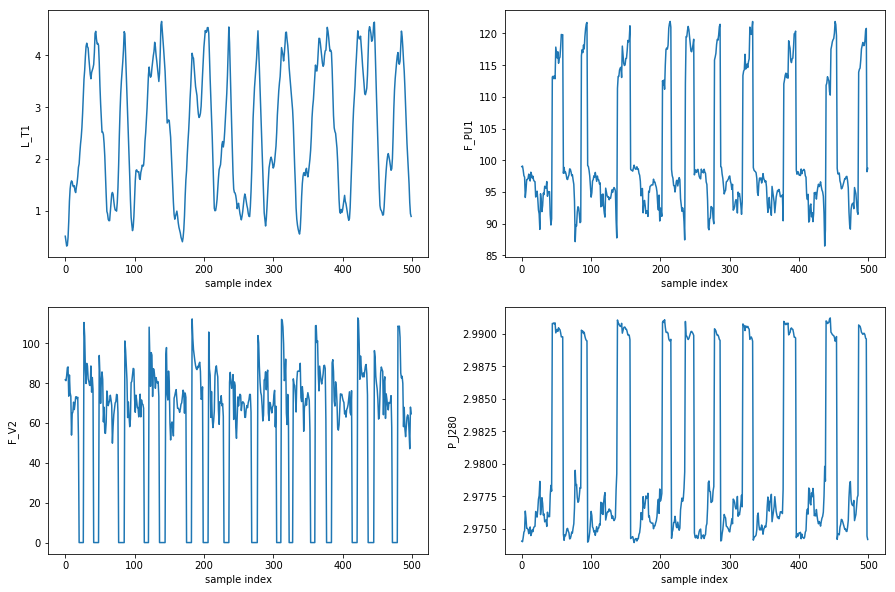

In [5]:
points_to_show = 500
fig, axis = plt.subplots(nrows=2, ncols=2, figsize = (15,10))
axis[0,0].plot(X1[:points_to_show, 0])
axis[0,0].set_ylabel("L_T1")
axis[0,0].set_xlabel("sample index")

axis[0,1].plot(X1[:points_to_show, 7])
axis[0,1].set_ylabel("F_PU1")
axis[0,1].set_xlabel("sample index")

axis[1,0].plot(X1[:points_to_show, 22])
axis[1,0].set_ylabel("F_V2")
axis[1,0].set_xlabel("sample index")

axis[1,1].plot(X1[:points_to_show, 24])
axis[1,1].set_ylabel("P_J280")
axis[1,1].set_xlabel("sample index")

More signals

Text(0.5, 0, 'sample index')

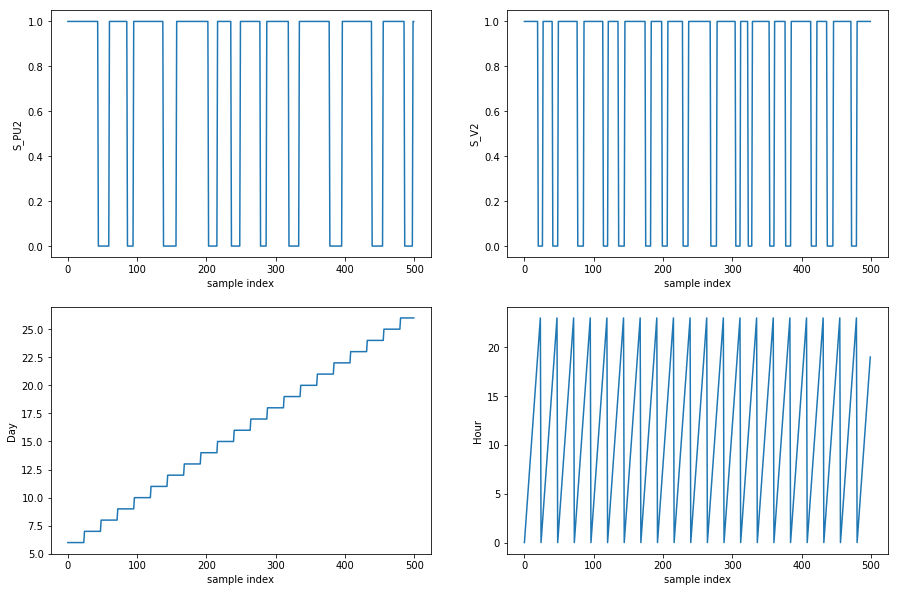

In [6]:
points_to_show = 500
fig, axis = plt.subplots(nrows=2, ncols=2, figsize = (15,10))
axis[0,0].plot(X1[:points_to_show, 9])
axis[0,0].set_ylabel("S_PU2")
axis[0,0].set_xlabel("sample index")

axis[0,1].plot(X1[:points_to_show, 23])
axis[0,1].set_ylabel("S_V2")
axis[0,1].set_xlabel("sample index")

axis[1,0].plot(X1[:points_to_show, 38])
axis[1,0].set_ylabel("Day")
axis[1,0].set_xlabel("sample index")

axis[1,1].plot(X1[:points_to_show, 39])
axis[1,1].set_ylabel("Hour")
axis[1,1].set_xlabel("sample index")

The following visualization compares values of the sensors across the 3 provided dataset. Thus, each row of the visualization corresponds to a single sensor signal and each column to a dataset (namely train1, train2, test)

Text(0.5, 0, 'sample index')

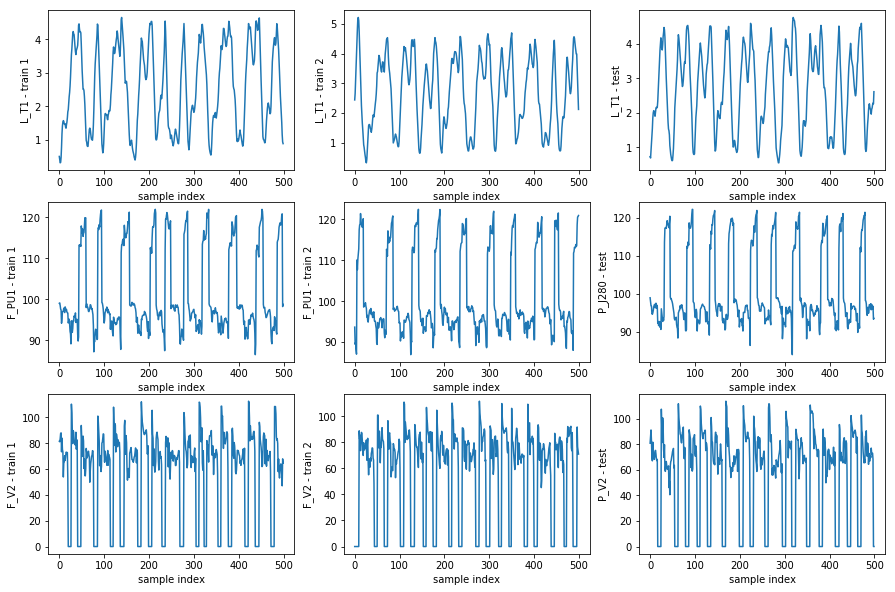

In [7]:
points_to_show = 500
fig, axis = plt.subplots(nrows=3, ncols=3, figsize = (15,10))
axis[0,0].plot(X1[:points_to_show, 0])
axis[0,0].set_ylabel("L_T1 - train 1")
axis[0,0].set_xlabel("sample index")
axis[0,1].plot(X2[:points_to_show, 0])
axis[0,1].set_ylabel("L_T1 - train 2")
axis[0,1].set_xlabel("sample index")
axis[0,2].plot(X_test[:points_to_show, 0])
axis[0,2].set_ylabel("L_T1 - test")
axis[0,2].set_xlabel("sample index")

axis[1,0].plot(X1[:points_to_show, 7])
axis[1,0].set_ylabel("F_PU1 - train 1")
axis[1,0].set_xlabel("sample index")
axis[1,1].plot(X2[:points_to_show, 7])
axis[1,1].set_ylabel("F_PU1 - train 2")
axis[1,1].set_xlabel("sample index")
axis[1,2].plot(X_test[:points_to_show, 7])
axis[1,2].set_ylabel("P_J280 - test")
axis[1,2].set_xlabel("sample index")

axis[2,0].plot(X1[:points_to_show, 22])
axis[2,0].set_ylabel("F_V2 - train 1")
axis[2,0].set_xlabel("sample index")
axis[2,1].plot(X2[:points_to_show, 22])
axis[2,1].set_ylabel("F_V2 - train 2")
axis[2,1].set_xlabel("sample index")
axis[2,2].plot(X_test[:points_to_show, 22])
axis[2,2].set_ylabel("P_V2 - test")
axis[2,2].set_xlabel("sample index")

The following plot demonstrates the attacks present in the second training dataset (as a reminder no attack occur in the frist set). For the following plot, we have modified the label -999 corresponding to unlabelled cases to 0 for better visualization outcome. 

In the second training set there are 219 samples corresponding to attack case and the rest are unlabelled (with a label of -999). We have 5 distinct attack cases

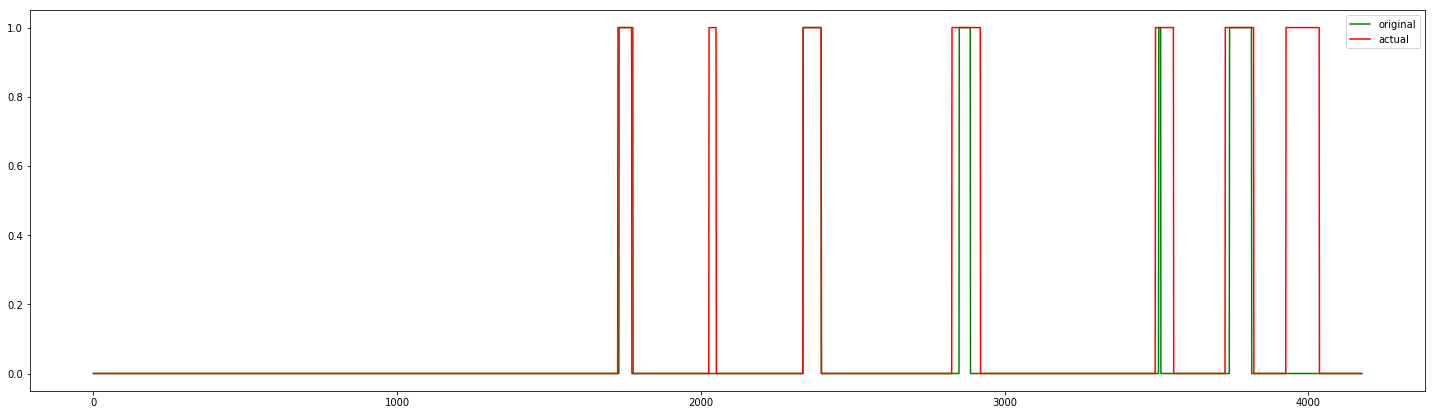

In [8]:
plt.figure(figsize=(25,7))
plt.plot(y2, color='g', label='original')
plt.plot(y2_actual, color='r', label='actual')
plt.legend()

## Correlation matrix

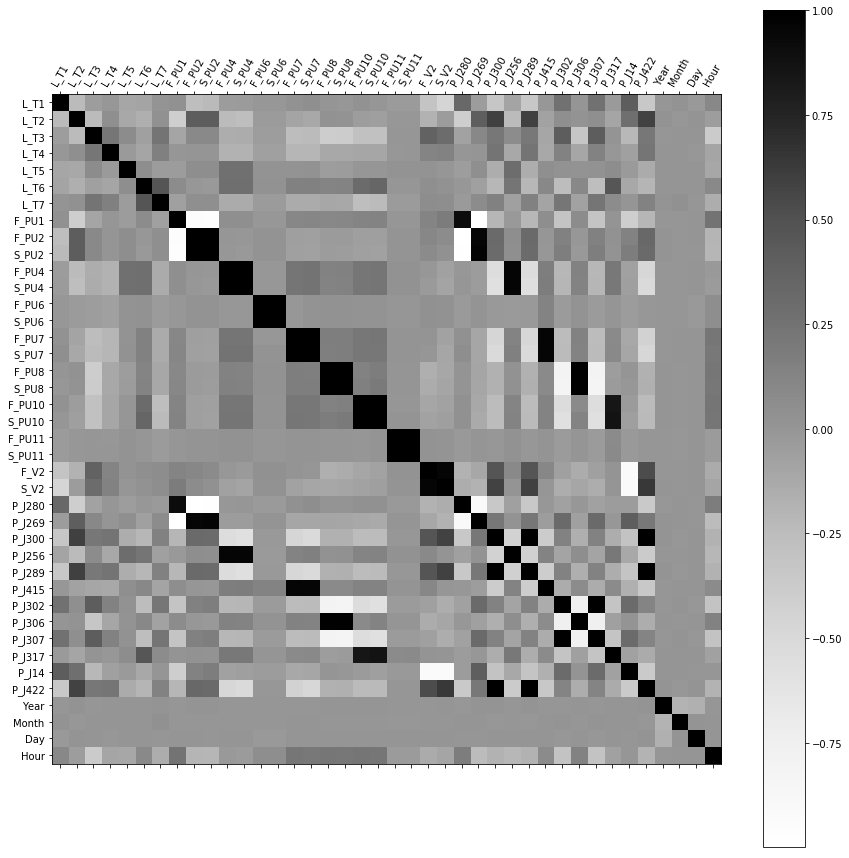

In [10]:
# Extract columns names corresponding to features with non-zero variance
labels = train_data.columns

plt.figure(figsize = (15,15))
corr_matrix = np.corrcoef(X1, rowvar=False)
plt.matshow(corr_matrix, fignum=1, cmap='Greys')
plt.xticks(range(len(labels)), labels, rotation=60)
plt.yticks(range(len(labels)), labels)
plt.colorbar()

## Prediction using a simple method

Here we made use of a single autoregressive model, making use of the previous value to predict the next value of the signal. Hence an ARMA model of order (1,0) was utilized.

In [11]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from helper_functions.comparison_helper_functions import *
from helper_functions.arma_helper_functions import *

# Fitting the ARMA model on L_T1 time series
signal = X1[:, 0]
model = ARMA(endog=signal, order=(1,0)).fit()
predictions = model.predict()

# To assess fitting extract the following criterion values
print("AIC: ", model.aic)
print("BIC: ", model.bic)

# Extract the Durbin-Watson test statistic. As a reminder a value close to 0 reveals positive auto-correlation
print("DW-test: ", sm.stats.durbin_watson(model.resid))

AIC:  -558.1004639865932
BIC:  -536.8662679885941
DW-test:  0.29607800631926867


Evaluate the quality of the fit. Compute mean forecaset and mean absolute error and plot true vs predicted value for the considered signal. 
The low value of the errors suggest that we have a good fit.

Mean Forecast error:  0.00024126802277403352
Mean Absolute error:  0.19345318632263309


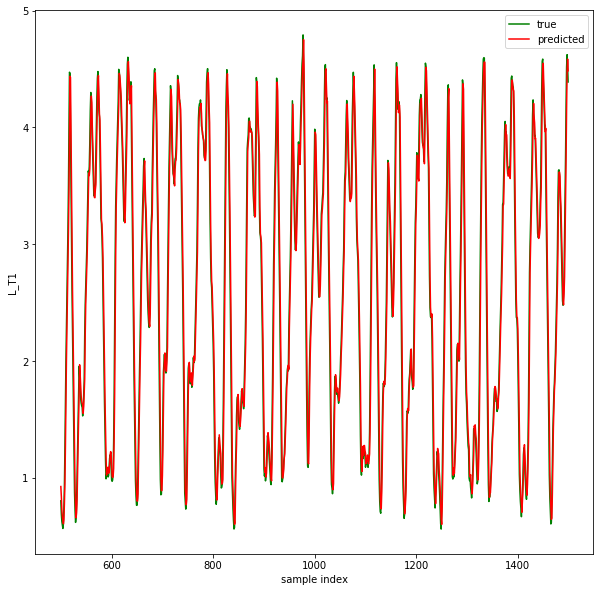

In [12]:
residuals = signal - predictions
MFE = np.mean(residuals)
MAE = np.mean(np.abs(residuals))
MAPE = np.mean(np.abs(residuals/(signal + 1e-32)))

print("Mean Forecast error: ", MFE)
print("Mean Absolute error: ", MAE)

offset = 500
points_to_show=1000
ind = np.arange(offset, offset+points_to_show, dtype=int)

plt.figure(figsize=(10,10))
plt.plot(ind, signal[ind], color='g', label='true')
plt.plot(ind, predictions[ind], color='r', label='predicted')

plt.xlabel("sample index")
plt.ylabel("L_T1")
plt.legend()

In [13]:
file = './data/arma_10_LT1.npy'
predictions, MFE, MAE, MAPE = predict(train_signal=X1[:, 0], test_signal=X2[:, 0], model_p=1, model_q=0, file=file)

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likel

Evalaute prediction with metrics and plot actual versus predicted values for the test signal.
Low MAE and MAPE revel a good fit.

Mean Forecast Error:  0.00027180621098157117
Mean Absolute Error:  0.08878732852767639
Mean Absolute Percentage Error:  0.09194


Text(0, 0.5, 'L_T1')

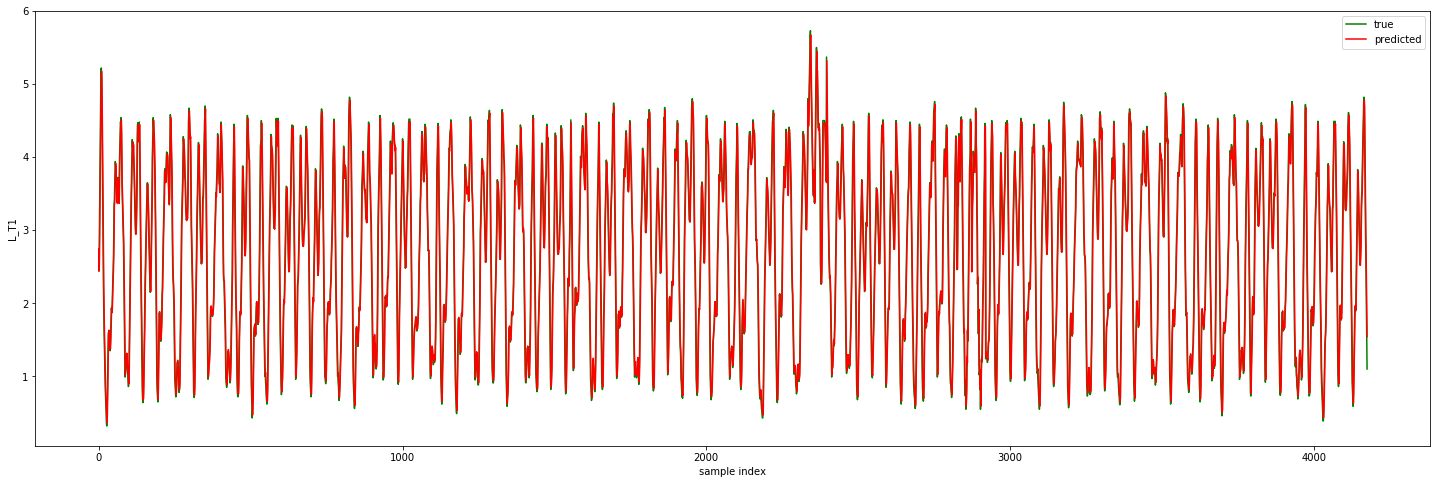

In [14]:
print("Mean Forecast Error: ", MFE)
print("Mean Absolute Error: ", MAE)
print("Mean Absolute Percentage Error: ", MAPE)

plt.figure(figsize =(25,8))
plt.plot(X2[:, 0], color='g', label ='true')
plt.plot(predictions[:], color='r', label='predicted')
plt.legend()
plt.xlabel("sample index")
plt.ylabel("L_T1")